In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from sympy.core.compatibility import (iterable, is_sequence, ordered,
    default_sort_key, range)

In [2]:
%matplotlib notebook
init_session()

IPython console for SymPy 1.0 (Python 2.7.12-32-bit) (ground types: python)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.0/


In [212]:
def ode2sys(ode, fun, x):
    """Rewrite an nth-order ODE as a system of first order ones
    """
    if not iterable(ode):
        ode = [ode]
        fun = [fun]
    orders = [ode_order(eq, f(x)) for eq, f in zip(ode, fun)]
    u = symbols("u:{}".format(sum(orders)))
    sys = []
    cont_var = 1
    for cont, eq in enumerate(ode):
        f = fun[cont]
        order = orders[cont]
        ode_aux = solve(eq, f(x).diff(x, order))[0]
        for cont in range(order - 1, -1, -1):
            ode_aux = ode_aux.subs({f(x).diff(x, cont): u[cont]})
        sys = sys + list(u[cont_var:cont_var + order])
        sys.append(ode_aux)
        cont_var = cont_var + order
    return u, sys

def ode2sys(ode, fun, x):
    """Rewrite an nth-order ODE as a system of first order ones
    """
    orders = ode_order(ode, fun(x))
    u = symbols("u:{}".format(order))
    ode_aux = solve(ode, fun(x).diff(x, order))[0]
    for cont in range(order - 1, -1, -1):
        ode_aux = ode_aux.subs({fun(x).diff(x, cont): u[cont]})
    sys = list(u[1:])
    sys.append(ode_aux)
    return u, sys

In [86]:
def critical_points(ode, fun, x):
    """Find critical points of an ODE"""
    u, sys = ode2sys(ode, fun, x)
    sol = solve(sys, u)
    return sol

In [172]:
def classify_critical_points(ode, fun, x):
    """Classify stability for critical points for 2D systems"""
    u, sys = ode2sys(ode, fun, x)
    sol = solve(sys, u)
    A = Matrix(sys).jacobian(u)
    stab = {xc: None for xc in sol}
    for xc in sol:
        B = A.subs({u[k]: xc[k] for k in range(len(u))})
        trace = B.trace()
        det = B.det()
        if det < 0:
            stab[xc] = "saddle"
        elif trace == 0:
            stab[xc] = "center"
        elif det > trace**2/4:
            if trace > 0:
                stab[xc] = "unstable spiral"
            else:
                stab[xc] = "stable spiral"
        else:
            if trace > 0:
                stab[xc] = "unstable node"
            else:
                stab[xc] = "stable node"
    return stab

In [151]:
def plotdf(ode, fun, x, xlim=(-5, 5), ylim=(-5, 5), nx=51, ny=51,
           args={None: None}, ax=None):
    """
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    u, sys = ode2sys(ode, fun, x)
    u_fun = lambdify(u, sys[0].subs(args), "numpy")
    v_fun = lambdify(u, sys[1].subs(args), "numpy")

    Y, X = np.mgrid[xlim[0]:xlim[1]:nx*1j, ylim[0]:ylim[1]:ny*1j]
    U = u_fun(X, Y)
    V = v_fun(X, Y)
    ax.streamplot(X, Y, U, V)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    return ax

## Simple pendulum

In [173]:
f = symbols("f", cls=Function)
x = symbols("x")
ode = f(x).diff(x, 2) + sin(f(x))
u, sys = ode2sys(ode, f, x)

<IPython.core.display.Javascript object>


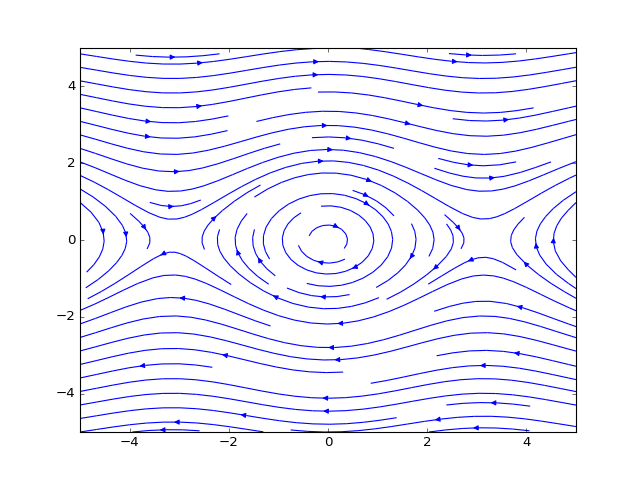

In [174]:
plotdf(ode, f, x)

In [128]:
critical_points(ode, f, x)

In [175]:
classify_critical_points(ode, f, x)

{(0, 0): 'center', (pi, 0): 'saddle'}

## Fourth order differential equation

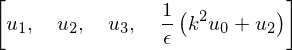

In [214]:
f = symbols("f", cls=Function)
x, k, eps = symbols("x k epsilon")
ode = f(x).diff(x, 2) - eps*f(x).diff(x, 4) + k**2*f(x)
u, sys = ode2sys(ode, f, x)
sys

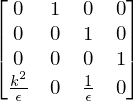

In [156]:
A = Matrix(sys).jacobian(u)
A

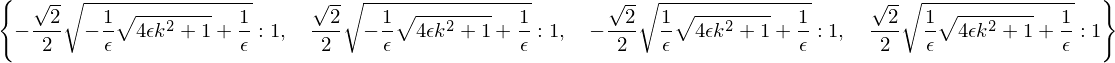

In [157]:
A.eigenvals()

## Conserved quantity

In [176]:
ode = f(x).diff(x, 2) - f(x)**5 + f(x)
u, sys = ode2sys(ode, f, x)
sys

In [177]:
sol = solve(sys, u)
sol

In [178]:
stab_pts = classify_critical_points(ode, f, x)
stab_pts

{(I, 0): 'saddle',
 (1, 0): 'saddle',
 (0, 0): 'center',
 (-I, 0): 'saddle',
 (-1, 0): 'saddle'}

<IPython.core.display.Javascript object>


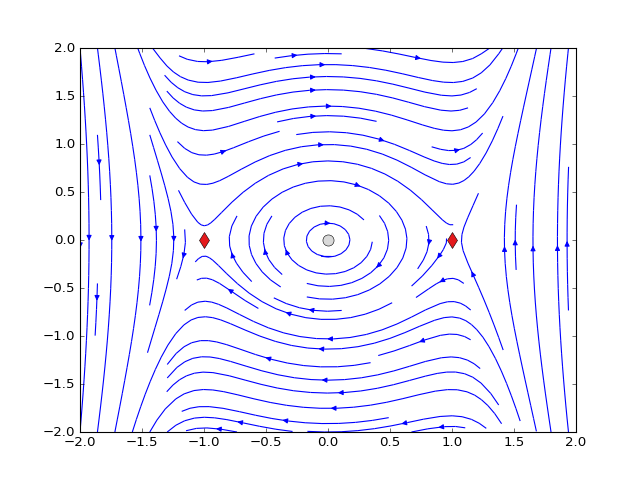

In [182]:
fig, ax = plt.subplots(1, 1)
ax = plotdf(ode, f, x, xlim=(-2, 2), ylim=(-2, 2), ax=ax)
markers = {
    "saddle": "d",
    "center": "o",
    "unstable spiral": "S",
    "stable spiral": "S",
    "unstable node": "D",
    "stable node": "D"}
marker_colors = {
    "saddle": "#e41a1c",
    "center": "#d9d9d9",
    "unstable spiral": "#e41a1c",
    "stable spiral": "#377eb8",
    "unstable node": "#e41a1c",
    "stable node": "#377eb8"}
for pt in sol:
    pt_x, pt_y = pt
    stab = stab_pts[pt]
    if pt_x.is_real and pt_y.is_real:
        ax.plot(pt_x, pt_y, marker=markers[stab], color=marker_colors[stab],
               markersize=10)

## Nonlinear nonhomogeneous second derivative

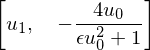

In [213]:
ode = f(x).diff(x, 2) + 4*f(x) + eps*f(x)**2*f(x).diff(x, 2)
u, sys = ode2sys(ode, f, x)
sys

<IPython.core.display.Javascript object>


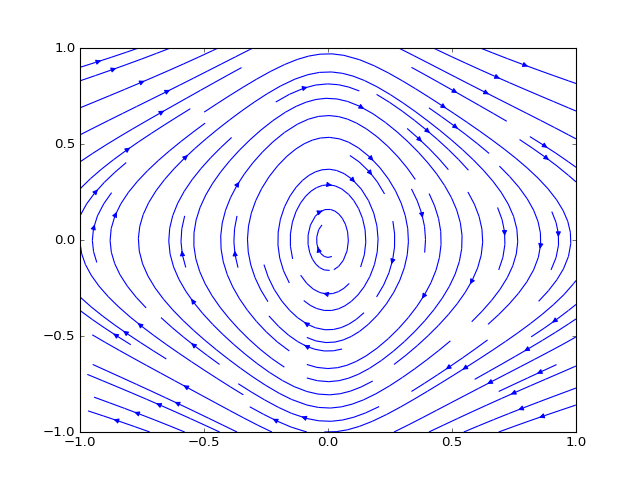

In [184]:
fig, ax = plt.subplots(1, 1)
plotdf(ode, f, x, xlim=(-1, 1), ylim=(-1, 1), args={eps: 10}, ax=ax)

## Coupled equation

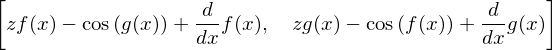

In [189]:
eq =  [f(x).diff(x) - cos(g(x)) + z*f(x), g(x).diff(x) - cos(f(x)) + z*g(x)]
eq

In [216]:
u, sys = ode2sys(eq, [f, g], x)

In [217]:
u

In [218]:
sys